# Data Analysis Interview Challenge

## Part 1 - EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
data_path = './logins.json'
df = pd.read_json(data_path)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Aggregate these login counts based on 15-minute time intervals
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.set_index('login_time')
df['count'] = 1
df = df.resample('15T').sum()
df.head(), df.tail()

(                     count
 login_time                
 1970-01-01 20:00:00      2
 1970-01-01 20:15:00      6
 1970-01-01 20:30:00      9
 1970-01-01 20:45:00      7
 1970-01-01 21:00:00      1,
                      count
 login_time                
 1970-04-13 17:45:00      5
 1970-04-13 18:00:00      5
 1970-04-13 18:15:00      2
 1970-04-13 18:30:00      7
 1970-04-13 18:45:00      6)

In [4]:
df.shape, df.describe()

((9788, 1),
              count
 count  9788.000000
 mean      9.515938
 std       8.328818
 min       0.000000
 25%       3.000000
 50%       7.000000
 75%      13.000000
 max      73.000000)

In [8]:
(df.index.max() - df.index.min())/ len(df.index)

Timedelta('0 days 00:14:59.908050674')

<AxesSubplot:title={'center':'Logins (15-min intervals)'}, xlabel='time', ylabel='Number of Logins'>

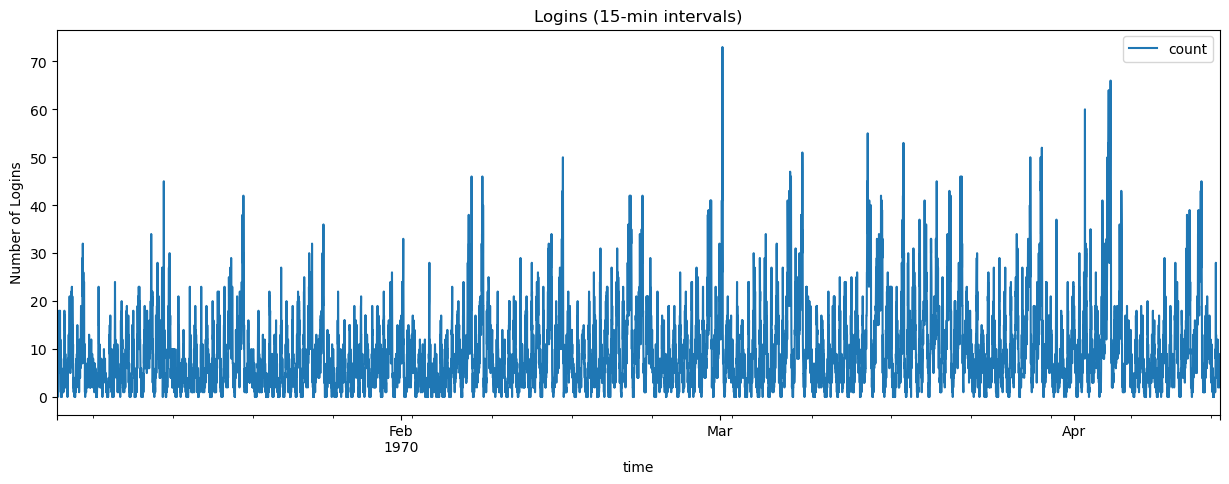

In [18]:
# visualize the time series and use full data for x ticks
import matplotlib.pyplot as plt
df.plot(figsize=(15,5), 
        xlabel="time", ylabel="Number of Logins", 
        title="Logins (15-min intervals)")

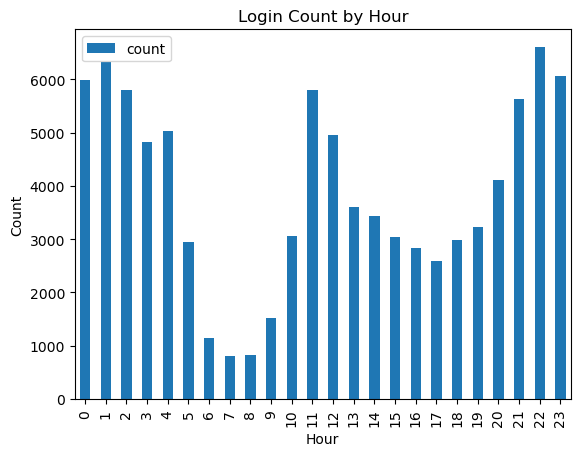

In [5]:
df.groupby(df.index.hour).sum().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Login Count by Hour')
plt.show()

Text(0.5, 1.0, 'Login Count by Day of Week')

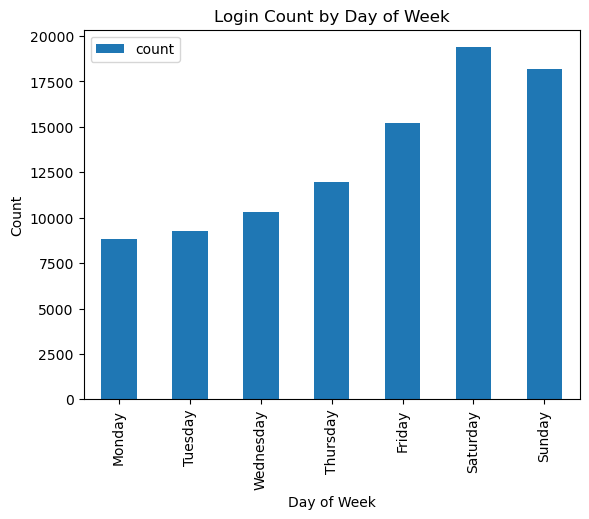

In [6]:
df.groupby(df.index.dayofweek).sum().plot(kind='bar')
plt.xlabel('Day of Week')
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.ylabel('Count')
plt.title('Login Count by Day of Week')

In [19]:
# what range of hours in a day has the highest login count?
range_of_hours = df.groupby(df.index.hour).sum()
range_of_hours.sort_values(by='count', ascending=False).head()

,count
login_time,
22,6607
1,6317
23,6058
0,5993
2,5800


1. The number of logins is higher during the night time (10pm-2am) than the day time.

In [20]:
# what day of week has the highest login count?
day_of_week = df.groupby(df.index.dayofweek).sum()
day_of_week.sort_values(by='count', ascending=False).head(2)

,count
login_time,
5,19377
6,18167


2. The number of logins is higher during the weekend than the weekdays.

In [22]:
# what range of hours in a day has the highest login count on the weekend?
weekend = df[df.index.dayofweek >= 5]
weekend.groupby(weekend.index.hour).sum().sort_values(by='count', ascending=False)

,count
login_time,
4,3826
3,3221
2,3216
1,2917
0,2377
5,2195
22,1745
15,1565
23,1563


3. The number of logins is highest between 12am and 5am on the weekends.

# Part 2 - Experiment and Metric design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Seeing as the goal for reimbursing drivers is to incentivize them to serve customers in both cities, I would say the key measure of success would be an increase in total number of drivers serving both cities. Choosing this metric is appropriate as we can assess whether the toll reimbursement policy successfully motivates them to cross the bridge. 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
> a. How you will implement the experiment

> b. what statistical test(s) you will conduct to verify the significance of the observation

> c. how you would interpret the results and provide the recommendations to the city operations team along with any caveats.

a.
To conduct the experiment, I would first attempt to collect all available data on the status of the current drivers. The most important would be recording the number of drivers serving both cities for a defined period before the introduction of the plicy. I would also record which drivers opperated exclusive to one city and whether they operated on weekdays, weekends, or both. 

Once the policy has been implemented, I would record the number of drivers serving both cities, for a period of time equivalent to pre-implementation. 

b. The paired t-test can compare the change in number of drivers serving both cities before and after the policy implementation to check for statistical significance.